In [1]:
!pip install  --quiet textblob
!pip install  --quiet nltk 
!pip install  --quiet datasets
!pip install --quiet wordcloud

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import re
from collections import Counter
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
import warnings

warnings.filterwarnings('ignore')

In [10]:
print("Downloading required NLTK data...")
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tayebekavousi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
# Load the dataset from Hugging Face
dataset = load_dataset("yelp_review_full")

# Convert to pandas DataFrame for easier analysis
df = pd.DataFrame(dataset['train'])

In [20]:
# Basic Data Exploration
print("Dataset Shape:", df.shape)
print("\nData Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
# Display first few rows
print("\nFirst few rows of the dataset:")
display(df.head())

Dataset Shape: (650000, 2)

Columns: ['label', 'text']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB

Missing Values:
label    0
text     0
dtype: int64

First few rows of the dataset:


,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [34]:
# Check unique values in label column
print("Unique ratings in the dataset:", sorted(df['label'].unique()))

# Calculate average rating
avg_rating = df['label'].mean()
print(f"\nAverage Rating: {avg_rating:.2f}")

# Add distribution statistics
print("\nRating Distribution:")
rating_dist = df['label'].value_counts().sort_index()
for rating in sorted(df['label'].unique()):
    count = rating_dist[rating]
    percentage = (count / len(df)) * 100
    print(f"Rating {rating}: {count:,} reviews ({percentage:.1f}%)")

Unique ratings in the dataset: [0, 1, 2, 3, 4]

Average Rating: 2.00

Rating Distribution:
Rating 0: 130,000 reviews (20.0%)
Rating 1: 130,000 reviews (20.0%)
Rating 2: 130,000 reviews (20.0%)
Rating 3: 130,000 reviews (20.0%)
Rating 4: 130,000 reviews (20.0%)


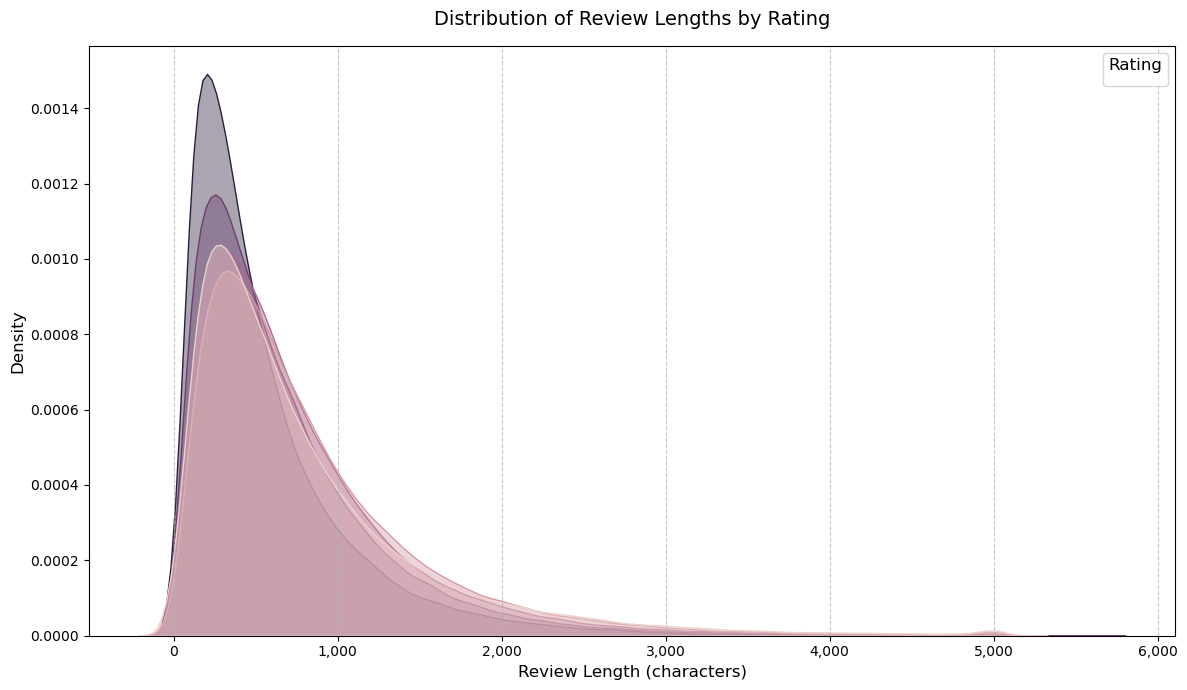


Review Length Statistics by Rating:
          count        mean         std  min    25%    50%     75%     max
label                                                                     
0      130000.0  815.307762  761.491098  1.0  308.0  581.0  1056.0  5115.0
1      130000.0  827.625792  705.651922  1.0  346.0  629.0  1084.0  5094.0
2      130000.0  758.695454  642.442217  2.0  320.0  582.0   998.0  5063.0
3      130000.0  680.159985  596.254734  4.0  272.0  512.0   899.0  5637.0
4      130000.0  579.838346  560.303570  1.0  220.0  408.0   741.0  5214.0

Correlation between rating and review length: -0.132


In [36]:
# Text Length Analysis
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))

# Create KDE plot for each rating
sns.kdeplot(data=df, x='text_length', hue='label', common_norm=False, 
            fill=True, alpha=0.4)

plt.title('Distribution of Review Lengths by Rating', fontsize=14, pad=15)
plt.xlabel('Review Length (characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Format x-axis with thousands separator
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

# Add legend with a title
plt.legend(title='Rating', title_fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nReview Length Statistics by Rating:")
length_stats = df.groupby('label')['text_length'].describe()
print(length_stats)

# Calculate correlation between rating and review length
correlation = df['label'].corr(df['text_length'])
print(f"\nCorrelation between rating and review length: {correlation:.3f}")

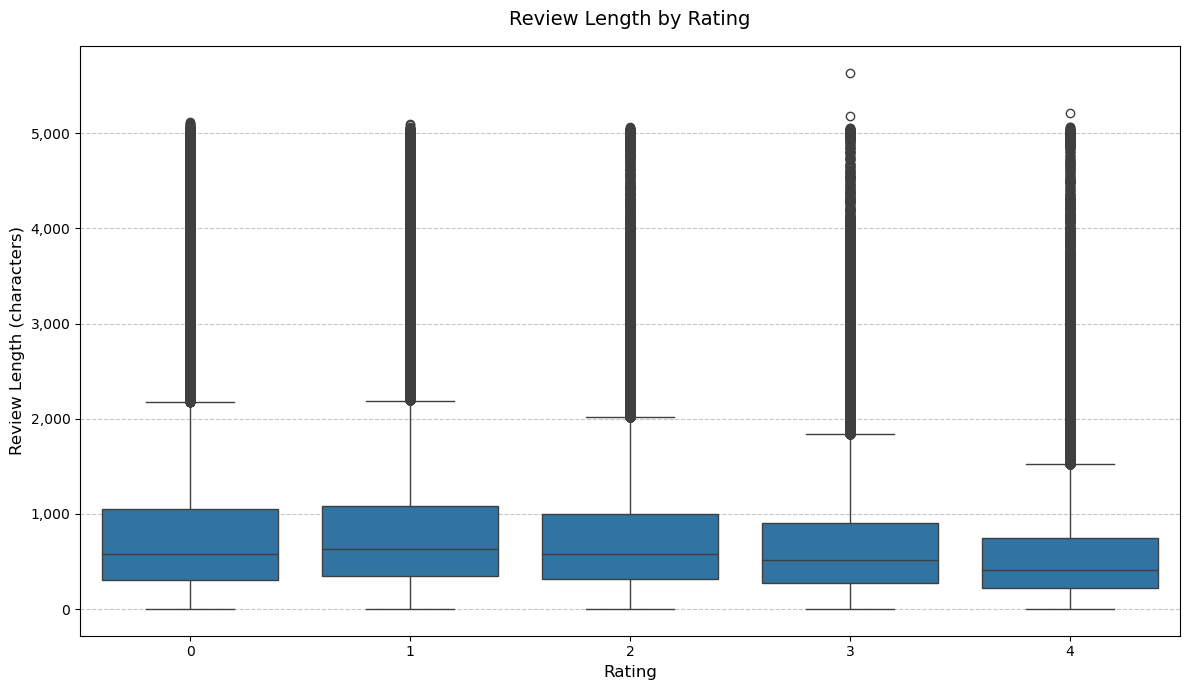


Review Length Statistics:
          count        mean         std  min    25%    50%     75%     max
label                                                                     
0      130000.0  815.307762  761.491098  1.0  308.0  581.0  1056.0  5115.0
1      130000.0  827.625792  705.651922  1.0  346.0  629.0  1084.0  5094.0
2      130000.0  758.695454  642.442217  2.0  320.0  582.0   998.0  5063.0
3      130000.0  680.159985  596.254734  4.0  272.0  512.0   899.0  5637.0
4      130000.0  579.838346  560.303570  1.0  220.0  408.0   741.0  5214.0

Average Review Length by Rating:
Rating 0: 815.3 characters
Rating 1: 827.6 characters
Rating 2: 758.7 characters
Rating 3: 680.2 characters
Rating 4: 579.8 characters


In [38]:
# Text Length Analysis
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Review Length by Rating', fontsize=14, pad=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Review Length (characters)', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis with thousands separator
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nReview Length Statistics:")
print(df.groupby('label')['text_length'].describe())

# Calculate mean length for each rating
mean_lengths = df.groupby('label')['text_length'].mean().round(1)
print("\nAverage Review Length by Rating:")
for rating, length in mean_lengths.items():
    print(f"Rating {rating}: {length:,.1f} characters")

In [42]:
# Function definitions
def preprocess_reviews(df):
    """
    Preprocess the review texts in the dataframe.
    """
    print("Starting text preprocessing...")
    
    # Create a lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Get stop words and add custom ones
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'br', 'the', 'and', 'to', 'of', 'a', 'i', 'it', 
                       'is', 'in', 'was', 'for', 'that', 'this', 'on', 
                       'at', 'they', 'there', 'have', 'had', 'what', 
                       'with', 'be', 'get', 'got', 'would', 'could'}
    stop_words.update(custom_stopwords)
    
    def clean_review(text):
        try:
            # Convert to lowercase
            text = str(text).lower()
            
            # Remove URLs
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            
            # Remove email addresses
            text = re.sub(r'\S+@\S+', '', text)
            
            # Remove special characters and numbers
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)
            
            # Split into words
            words = text.split()
            
            # Remove stop words and lemmatize
            cleaned_words = [lemmatizer.lemmatize(word) for word in words 
                           if word not in stop_words and len(word) > 2]
            
            # Join words back into text
            return ' '.join(cleaned_words)
        except Exception as e:
            print(f"Error processing text: {str(e)}")
            return ""
    
    # Create new column with cleaned text
    print("Cleaning and normalizing reviews...")
    df['cleaned_text'] = df['text'].apply(clean_review)
    
    print("Preprocessing complete!")
    return df


def generate_wordcloud(text, title, background_color='white'):
    """
    Generate and display a word cloud from text.
    
    Args:
        text (str): Text to generate word cloud from
        title (str): Title for the word cloud
        background_color (str): Background color for the word cloud (default: 'white')
    """
    # Create word cloud object
    wordcloud = WordCloud(
        width=1600,           # Increased width for better resolution
        height=800,           # Increased height for better resolution
        background_color=background_color,
        max_words=150,        # Increased max words
        collocations=False,   # Avoid repeating word pairs
        min_font_size=10,
        max_font_size=150,
        random_state=42       # For reproducibility
    ).generate(text)
    
    # Create figure with higher DPI for better quality
    plt.figure(figsize=(20, 10), dpi=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout(pad=0)
    plt.show()

In [44]:
print("Starting preprocessing of reviews...")
df_processed = preprocess_reviews(df)

Starting preprocessing of reviews...
Starting text preprocessing...
Cleaning and normalizing reviews...
Preprocessing complete!


In [46]:
# Add sentiment column based on ratings
df['sentiment'] = df['label'].map(
    lambda x: -1 if x <= 1 else (1 if x >= 3 else 0)
)

# Verify the mapping
sentiment_counts = df['sentiment'].value_counts().sort_index()
print("\nSentiment Distribution:")
print("Negative (-1):", sentiment_counts[-1])
print("Neutral (0):", sentiment_counts[0])
print("Positive (1):", sentiment_counts[1])

# Show percentages
total = len(df)
print("\nSentiment Distribution (%):")
print("Negative (-1):", f"{(sentiment_counts[-1]/total)*100:.1f}%")
print("Neutral (0):", f"{(sentiment_counts[0]/total)*100:.1f}%")
print("Positive (1):", f"{(sentiment_counts[1]/total)*100:.1f}%")


Sentiment Distribution:
Negative (-1): 260000
Neutral (0): 130000
Positive (1): 260000

Sentiment Distribution (%):
Negative (-1): 40.0%
Neutral (0): 20.0%
Positive (1): 40.0%



Generating word clouds for different sentiment categories...

Generating word cloud for negative sentiment reviews...


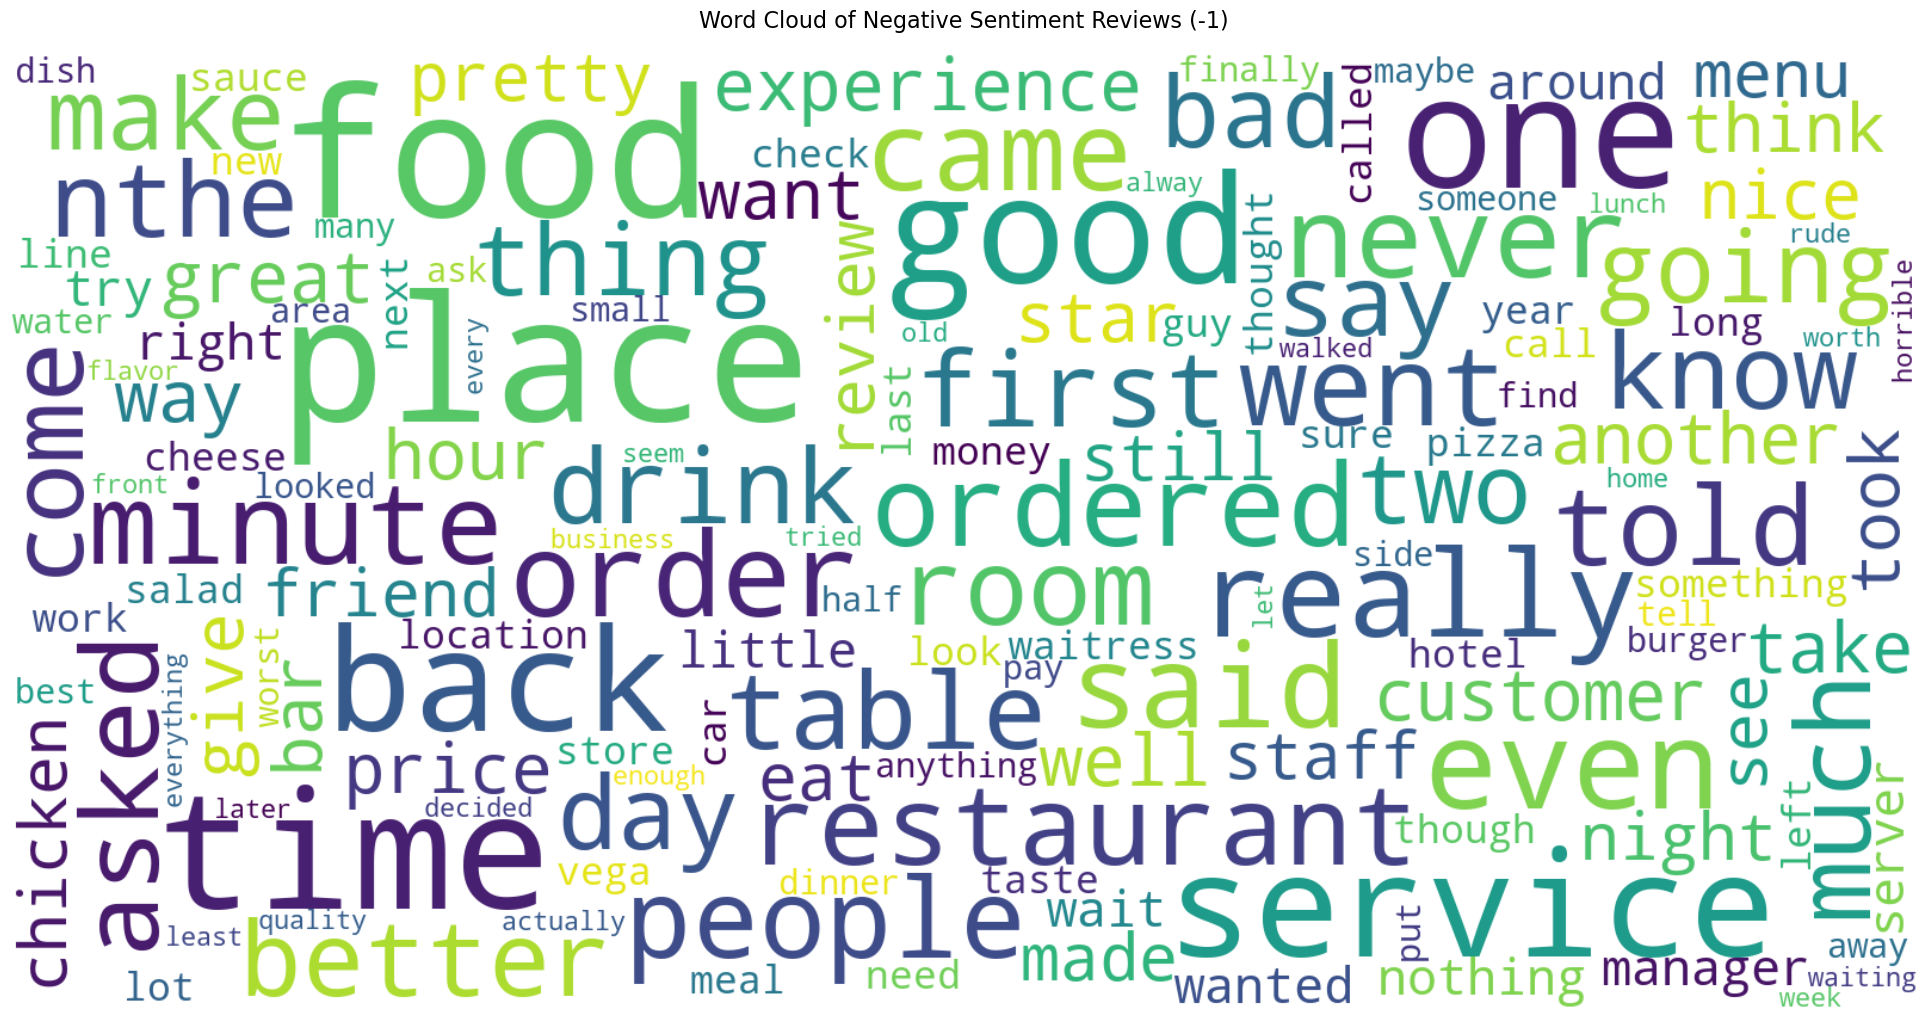


Generating word cloud for neutral sentiment reviews...


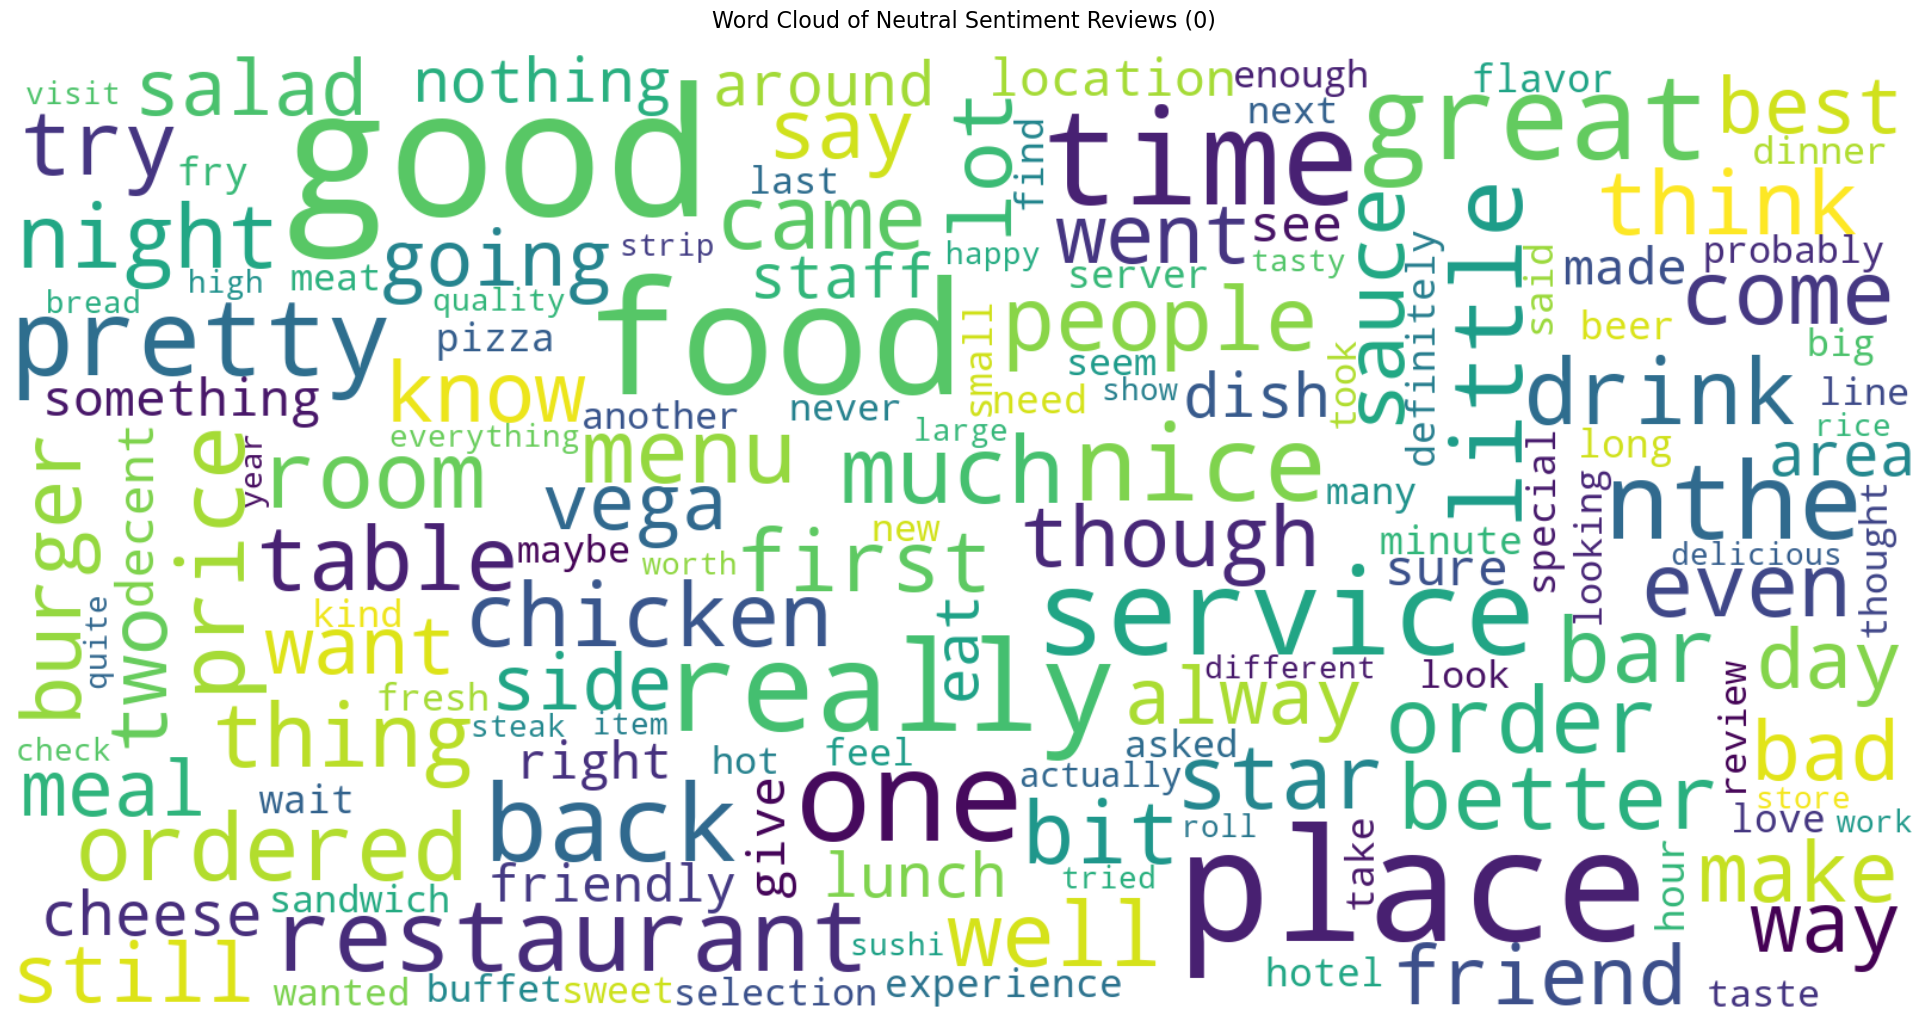


Generating word cloud for positive sentiment reviews...


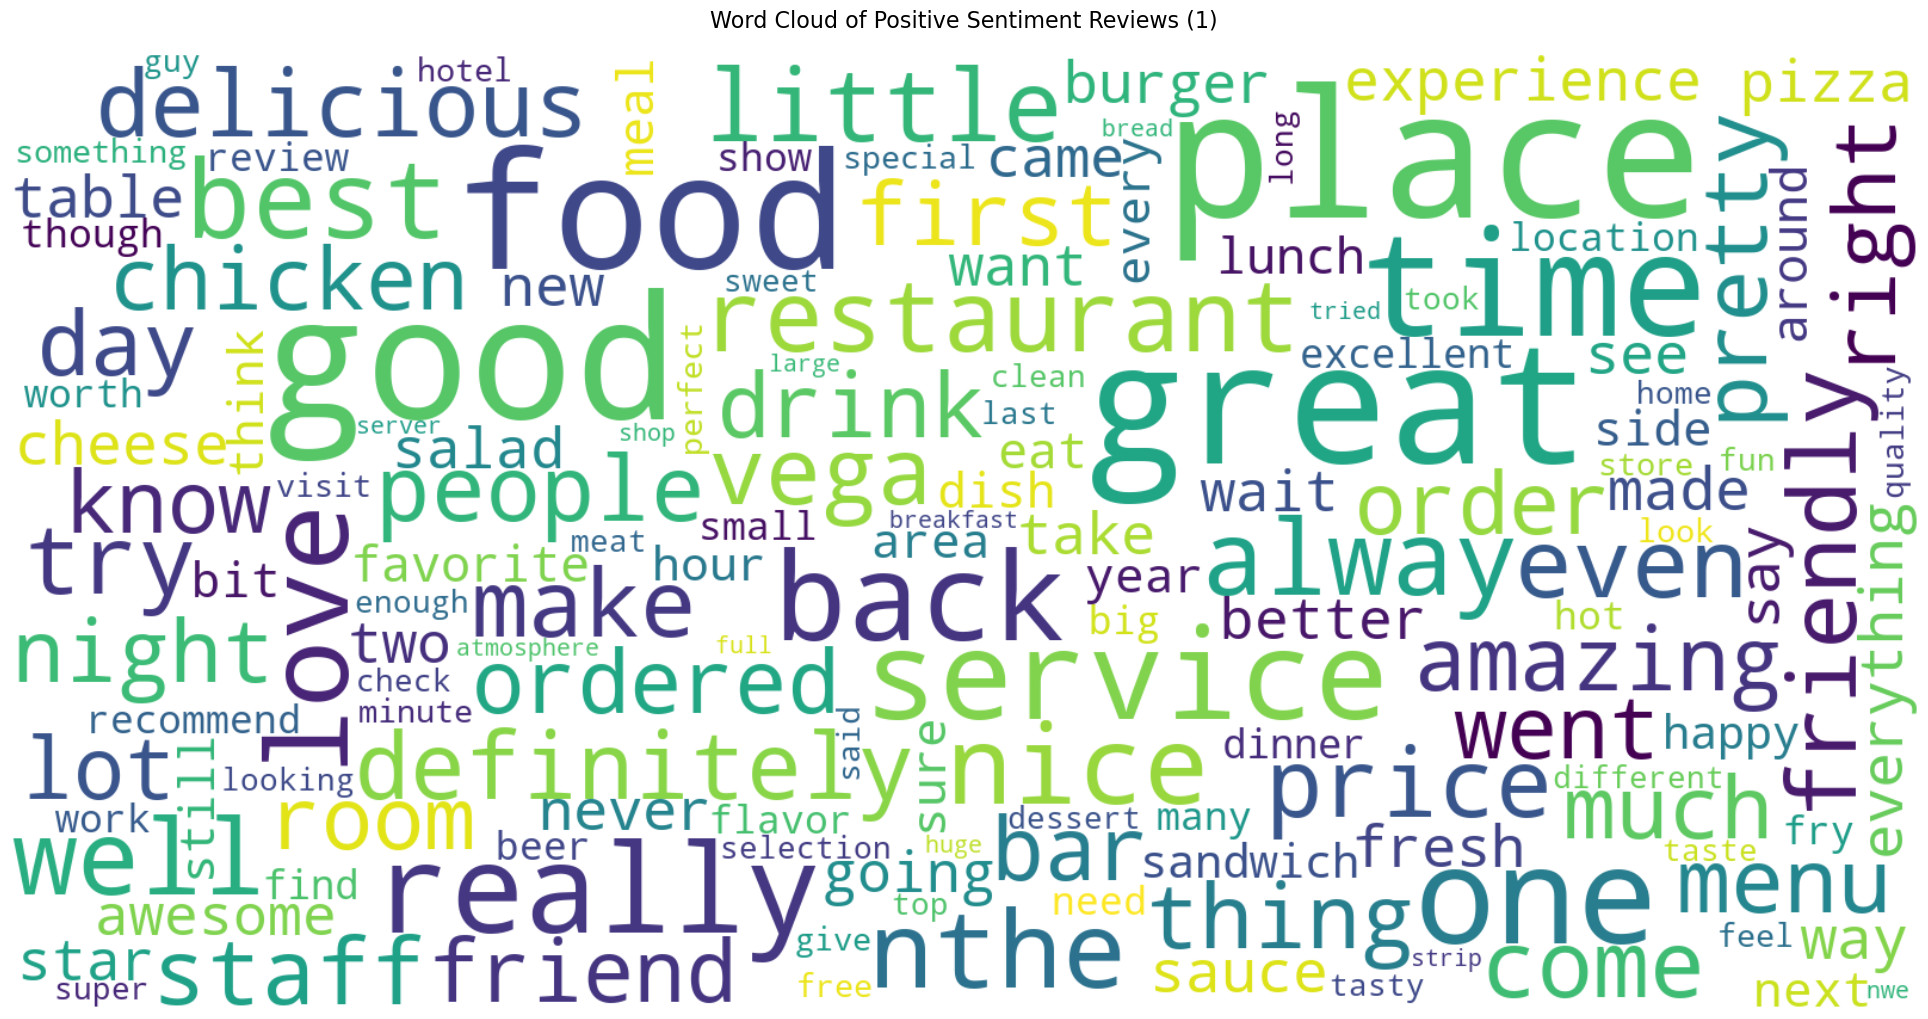


Sentiment Distribution:
Negative sentiment (-1): 260,000 reviews (40.0%)
Neutral sentiment (0): 130,000 reviews (20.0%)
Positive sentiment (1): 260,000 reviews (40.0%)


In [48]:
# Generate word clouds using the cleaned text for each sentiment class
print("\nGenerating word clouds for different sentiment categories...")

# 1. Negative Sentiment (-1)
print("\nGenerating word cloud for negative sentiment reviews...")
negative_df = df[df['sentiment'] == -1]
negative_sample = negative_df.sample(n=min(5000, len(negative_df)))
negative_text = ' '.join(negative_sample['cleaned_text'])
generate_wordcloud(negative_text, 'Word Cloud of Negative Sentiment Reviews (-1)', 'white')

# 2. Neutral Sentiment (0)
print("\nGenerating word cloud for neutral sentiment reviews...")
neutral_df = df[df['sentiment'] == 0]
neutral_sample = neutral_df.sample(n=min(5000, len(neutral_df)))
neutral_text = ' '.join(neutral_sample['cleaned_text'])
generate_wordcloud(neutral_text, 'Word Cloud of Neutral Sentiment Reviews (0)', 'white')

# 3. Positive Sentiment (1)
print("\nGenerating word cloud for positive sentiment reviews...")
positive_df = df[df['sentiment'] == 1]
positive_sample = positive_df.sample(n=min(5000, len(positive_df)))
positive_text = ' '.join(positive_sample['cleaned_text'])
generate_wordcloud(positive_text, 'Word Cloud of Positive Sentiment Reviews (1)', 'white')

# Print statistics
print("\nSentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts().sort_index()
total_count = len(df)

for sentiment_value in [-1, 0, 1]:
    count = sentiment_counts[sentiment_value]
    percentage = (count / total_count) * 100
    sentiment_name = {-1: "Negative", 0: "Neutral", 1: "Positive"}[sentiment_value]
    print(f"{sentiment_name} sentiment ({sentiment_value}): {count:,} reviews ({percentage:.1f}%)")


Text Length Statistics by Sentiment:
              count        mean         std  min    25%    50%    75%     max
sentiment                                                                    
-1         260000.0  465.628158  414.886354  0.0  186.0  343.0  607.0  4064.0
 0         130000.0  439.271862  374.404098  0.0  184.0  336.0  576.0  3518.0
 1         260000.0  373.658135  343.899606  0.0  147.0  271.0  486.0  3914.0

Average Review Lengths:
Negative: 465.6 characters
Neutral: 439.3 characters
Positive: 373.7 characters


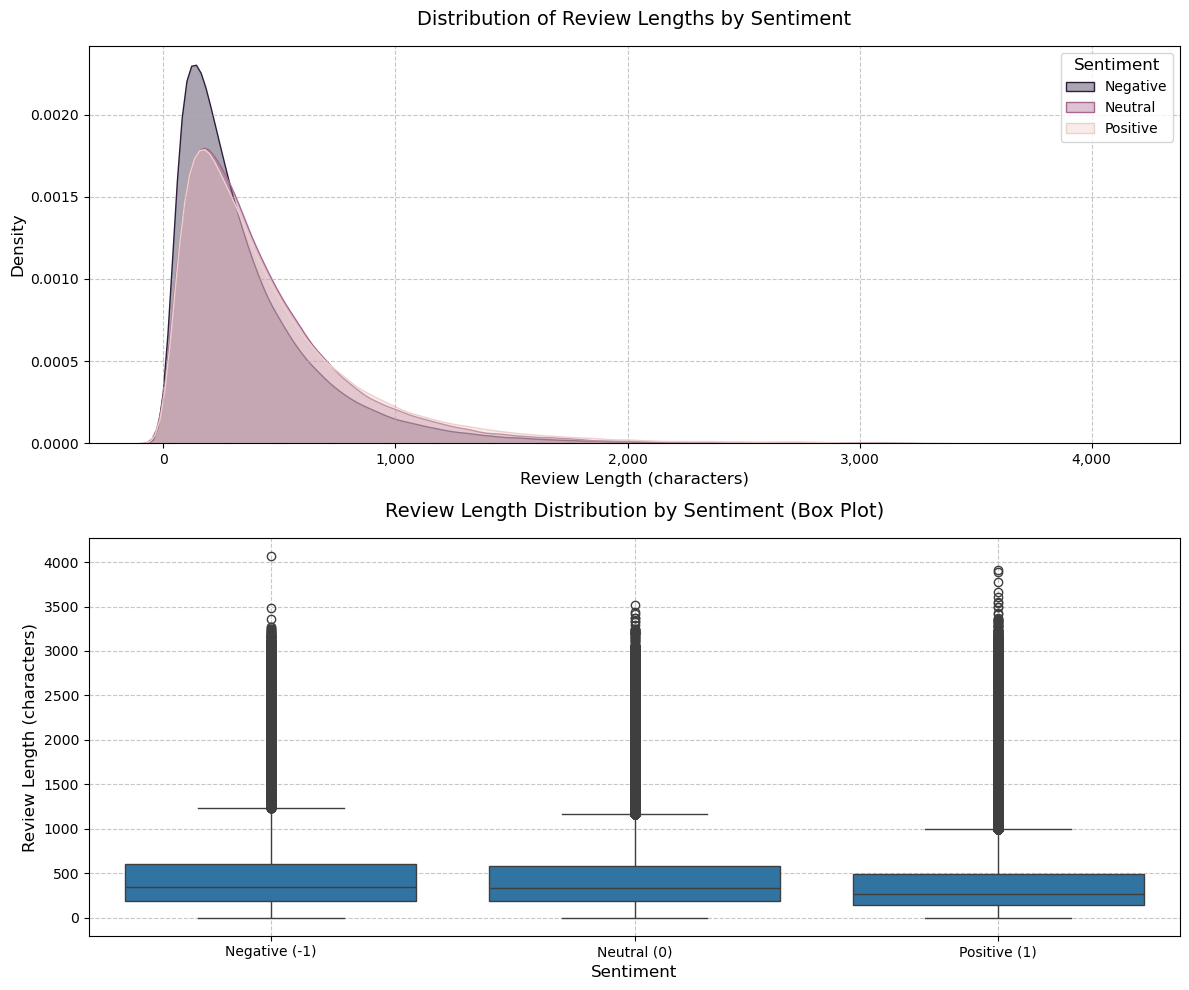

In [52]:
# Calculate text lengths
df['text_length'] = df['cleaned_text'].str.len()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Distribution plot
sns.kdeplot(data=df, x='text_length', hue='sentiment', 
            common_norm=False, fill=True, alpha=0.4, ax=ax1)
ax1.set_title('Distribution of Review Lengths by Sentiment', fontsize=14, pad=15)
ax1.set_xlabel('Review Length (characters)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Format x-axis with thousands separator
current_values = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

# Add legend with descriptive labels
sentiment_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
ax1.legend(title='Sentiment', title_fontsize=12, 
          labels=['Negative', 'Neutral', 'Positive'])

# Plot 2: Box plot for a different perspective
sns.boxplot(x='sentiment', y='text_length', data=df, ax=ax2)
ax2.set_title('Review Length Distribution by Sentiment (Box Plot)', fontsize=14, pad=15)
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Review Length (characters)', fontsize=12)
ax2.set_xticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
ax2.grid(True, linestyle='--', alpha=0.7)

# Calculate and print summary statistics
stats = df.groupby('sentiment')['text_length'].describe()
print("\nText Length Statistics by Sentiment:")
print(stats)

# Calculate averages for each sentiment
averages = df.groupby('sentiment')['text_length'].mean()
print("\nAverage Review Lengths:")
for sentiment in [-1, 0, 1]:
    print(f"{sentiment_labels[sentiment]}: {averages[sentiment]:.1f} characters")

plt.tight_layout()
plt.show()

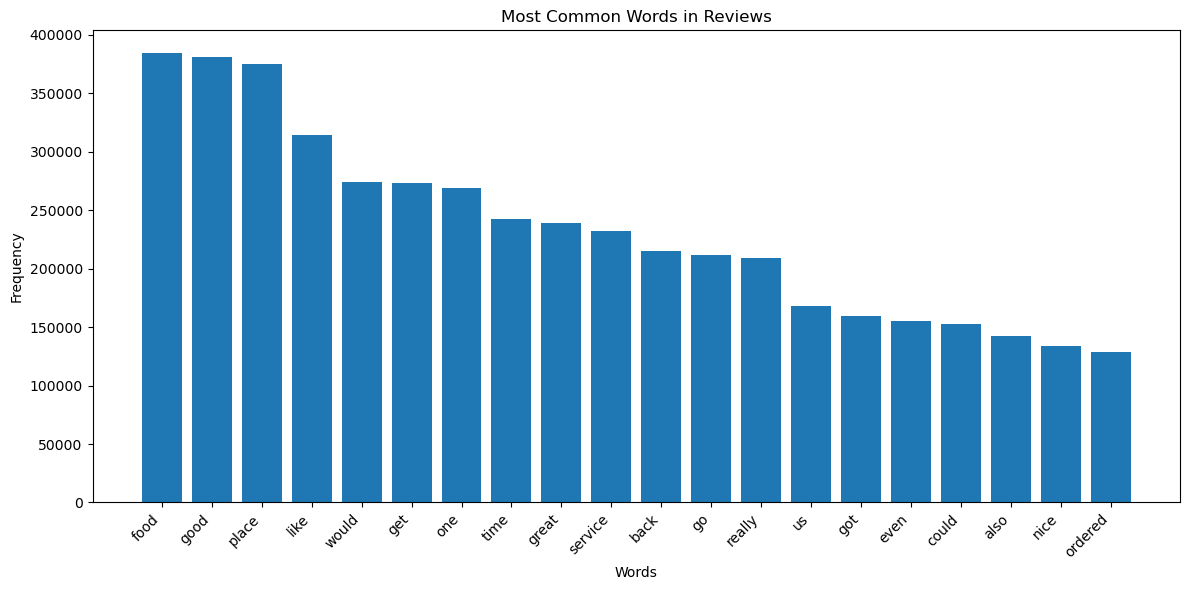

In [54]:
# 6. Common Words Analysis
def get_common_words(texts, n=20):
    stop_words = set(stopwords.words('english'))
    words = []
    
    for text in texts:
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens 
                     if word.isalnum() and word not in stop_words])
    
    return Counter(words).most_common(n)

# Get most common words overall
common_words = get_common_words(df['text'])

plt.figure(figsize=(12, 6))
words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

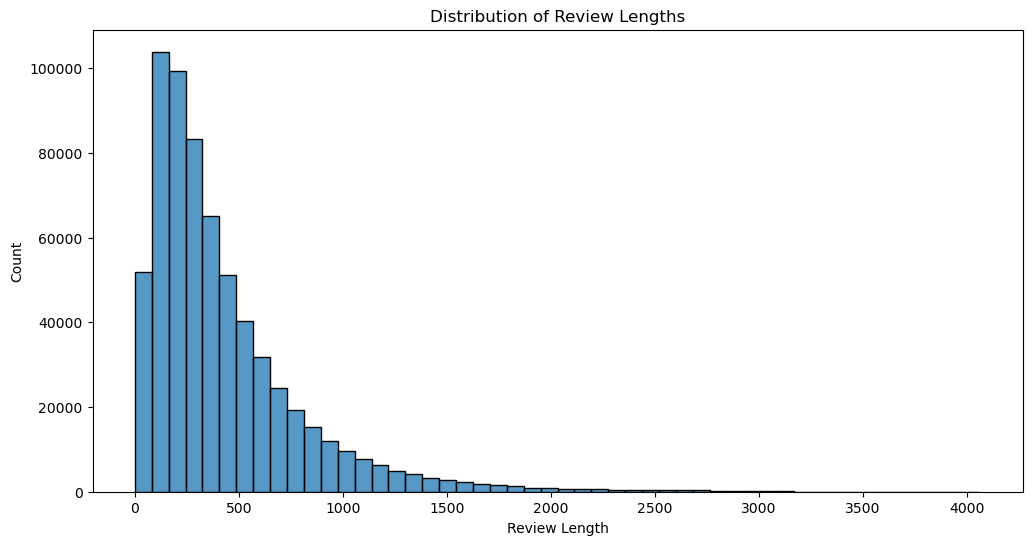


Summary Statistics for Review Length:
count    650000.000000
mean        423.568889
std         382.030942
min           0.000000
25%         168.000000
50%         311.000000
75%         552.000000
max        4064.000000
Name: text_length, dtype: float64


In [56]:
# 7. Review Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

print("\nSummary Statistics for Review Length:")
print(df['text_length'].describe())

In [58]:
# 9. Save insights to a file
with open('yelp_analysis_insights.txt', 'w') as f:
    f.write(f"Yelp Reviews Analysis Insights\n")
    f.write(f"===========================\n\n")
    f.write(f"Dataset Statistics:\n")
    f.write(f"- Total number of reviews: {len(df)}\n")
    f.write(f"- Average rating: {avg_rating:.2f}\n")
    f.write(f"- Average review length: {df['text_length'].mean():.2f} characters\n")
    f.write(f"- Average sentiment score: {df['sentiment'].mean():.2f}\n")